In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os


In [2]:
DATA_DIR = "/Users/timberzhang/Documents/Documents/2024-JustWatch/Data"
FILL_NAN = np.nan
CLUSTER_MIN_EPS = 25
CLUSTER_MIN_SAMPLE = 5

VR_SCALE = 0.001207812
VR_ZDIST = 1
EYE_SAMPLE_RATE = 50
EYE_SAMPLE_TIME = (1 / EYE_SAMPLE_RATE) * 1000
SCREEN_SIZE = [1280, 720]

VIDEO_SIZE = [1920, 1080]
VIDEO_FPS = 30
BALL_TRAJ = None

In [3]:

def fetch_eye_data(_raw_eye_data:str):
    _eye_data_rows = _raw_eye_data.split(";")
    eye_data = {}   
    names = _eye_data_rows[0].split(" ")
    for idx, row in enumerate(_eye_data_rows):
        if idx == 0 : continue

        cur_data = row.split(" ")
        try:
            eye_data[idx] = {
                names[0] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[0]),
                names[1] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[1]),
                names[2] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[2]),
                names[3] : FILL_NAN if cur_data[0]=="NaN" else float(cur_data[3]),
            }
        except:
            eye_data[idx] = {
                names[0] : FILL_NAN,
                names[1] : FILL_NAN,
                names[2] : FILL_NAN,
                names[3] : FILL_NAN,
            }

    return eye_data


In [4]:

def fetch_trajectory(dir_path:str):
    res = {}

    p_traj = pd.read_csv(os.path.join(dir_path, "pingpang.csv"))
    w_traj = pd.read_csv(os.path.join(dir_path, "tennis.csv"))
    _temp_all = pd.concat([p_traj, w_traj], axis=0)
    _temp_all["position"] = _temp_all["position"].apply(lambda x : x.replace(" ", ""))

    for v_id, v_df in _temp_all.groupby(by="video_name"):

        _x = v_df["position"].apply(lambda x : x.split(",")[0][1:]).to_numpy(dtype=np.int16)
        _y = v_df["position"].apply(lambda x : x.split(",")[1][:-1]).to_numpy(dtype=np.int16)

        # reverse the y-axis
        _y = (_y - VIDEO_SIZE[1]) * -1

        # scale and shift
        _x = (_x / VIDEO_SIZE[0]) * SCREEN_SIZE[0] - (SCREEN_SIZE[0] // 2)
        _y = (_y / VIDEO_SIZE[1]) * SCREEN_SIZE[1] - (SCREEN_SIZE[1] // 2)

        _f = v_df["frame_number"].to_numpy(dtype=np.int16)
        _r = v_df["round"].to_numpy(dtype=np.int16)
        _temp_df = pd.DataFrame(
            np.array([_f, _x, _y, _r]),
        ).T
        _temp_df.index = range(1, _f.size+1)
        _temp_df.columns = ["frame", "Ball.x", "Ball.y", "round"]

        res[v_id] = _temp_df.to_dict()

    return res

In [5]:
def interplate_and_align(base_df:pd.DataFrame, align_df:pd.DataFrame, base_rate:int, align_rate:int, convert_dist=False):
    share_rate = abs(base_rate * align_rate) // np.gcd(base_rate, align_rate)
    
    align_df["frame"] = align_df["frame"] * (share_rate // align_rate)
    temp_index= np.array(range(1, int(base_df["frame"].max()+1) * (share_rate // base_rate)))

    temp_time_df = pd.DataFrame(temp_index, index=temp_index, columns=["frame"])
    _index = temp_time_df.index
    temp_time_df = temp_time_df.merge(align_df, how="left", on="frame")
    temp_time_df.index = _index
    ## interplate
    for col in temp_time_df.columns:
        if col=="round": continue
        temp_time_df[col] = temp_time_df[col].interpolate(method='linear')
    ## ensure first row is not empty
    temp_time_df.ffill(inplace=True)
    temp_time_df.bfill(inplace=True)
    
    base_df["frame"] = base_df["frame"] * (share_rate // base_rate)
    _index = base_df.index
    alined_df = base_df.merge(temp_time_df, how="left", on="frame", )
    alined_df.index = _index
    alined_df["frame"] = alined_df["frame"] // (share_rate // base_rate)

    if convert_dist:
        alined_df = alined_df * VR_SCALE
        alined_df["frame"] = alined_df["frame"] // VR_SCALE

    alined_df.ffill(inplace=True)
    alined_df.bfill(inplace=True)

    return alined_df

In [6]:
['24071512_AD.csv',
 '24070902_AD.csv',
 '24071009_AD.csv',
 '24072825_AD.csv',
 '24070904_AD.csv',
 '24071617_AD.csv',
 '24071721_AD.csv',
 '24071619_AD.csv',
 '24071615_AD.csv',
 '24071011_AD.csv',
 '24070906_AD.csv',
 'Test_AD.csv',
 '24071513_AD.csv',
 '24072926_AD.csv',
 '24071008_AD.csv',
 '24070901_AD.csv',
 '24072023_AD.csv',
 '24071616_AD.csv',
 '24070905_AD.csv',
 '24070907_AD.csv',
 '24071010_AD.csv',
 '24071618_AD.csv']

['24071512_AD.csv',
 '24070902_AD.csv',
 '24071009_AD.csv',
 '24072825_AD.csv',
 '24070904_AD.csv',
 '24071617_AD.csv',
 '24071721_AD.csv',
 '24071619_AD.csv',
 '24071615_AD.csv',
 '24071011_AD.csv',
 '24070906_AD.csv',
 'Test_AD.csv',
 '24071513_AD.csv',
 '24072926_AD.csv',
 '24071008_AD.csv',
 '24070901_AD.csv',
 '24072023_AD.csv',
 '24071616_AD.csv',
 '24070905_AD.csv',
 '24070907_AD.csv',
 '24071010_AD.csv',
 '24071618_AD.csv']

In [7]:
data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/Test_AD.csv")
# data = pd.read_csv("/Users/timberzhang/Documents/Documents/2024-JustWatch/Data/24071512_AD.csv")


In [8]:
_single_person_data_dict = {}
_videos = {}

for _, row in data.iterrows():
    _eye_data = fetch_eye_data(row["EyeData"])
    v_id = row["videoName"]
    if v_id in _single_person_data_dict.keys(): 
        _videos[v_id] += 1
        v_id = v_id + f"_{_videos[v_id]}"
    else:
        _videos[v_id] = 1
    _single_person_data_dict[v_id] = _eye_data

In [9]:
BALL_TRAJ = fetch_trajectory(DATA_DIR)

In [10]:
video_id = "p7"
ball_data = pd.DataFrame(BALL_TRAJ[video_id.split("_")[0]])

In [11]:
eye_data = pd.DataFrame(_single_person_data_dict[video_id]).T
eye_data.ffill(inplace=True)
eye_data.bfill(inplace=True)

eye_data

Screen.x  Screen.y  LeftPupil  RightPupil
1     -6.936387  31.41264   3.760830    2.750577
2    -17.236250  74.94171   3.472282    2.975615
3    -26.844490  67.97930   3.625612    3.156161
4    -27.533650  63.76825   3.764647    3.302529
5    -34.519730  66.01138   3.849909    3.203750
..          ...       ...        ...         ...
819 -172.378700 -52.00825   4.150671    3.772168
820 -172.451200 -52.26285   4.150671    3.772168
821 -173.047500 -49.60559   4.202515    3.625865
822 -174.990900 -54.17878   4.149105    3.789877
823 -174.990900 -54.17878   4.149105    3.789877

[823 rows x 4 columns]

In [12]:

eye_data.ffill(inplace=True)
eye_data.bfill(inplace=True)

In [13]:
from sklearn.cluster import DBSCAN
import numpy as np
from random import random

db = DBSCAN(eps=25, min_samples=5)
temp = np.array([eye_data["Screen.x"], eye_data["Screen.y"], eye_data.index.to_numpy()]).T
cluster = db.fit(temp)
classes = pd.value_counts(cluster.labels_).index
color_dict = {c:(random(), random(), random()) for c in classes}

temp = pd.DataFrame(temp)
temp.columns=["x", "y", "t"]
temp["c"] = cluster.labels_
temp["color"] = temp["c"].map(color_dict)

/var/folders/rp/3xmh9dds7tl2vhpb6h3ntl1r0000gn/T/ipykernel_6082/1039114426.py:8: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  classes = pd.value_counts(cluster.labels_).index


In [14]:
temp["c"].value_counts(sort=False)

c
-1     38
 0     11
 1     18
 2     27
 3     13
 4     28
 5     19
 6     44
 7     12
 9     20
 8     15
 10    17
 11    26
 12    20
 13     7
 14    14
 15    15
 16    13
 17    13
 18    11
 19    25
 20    23
 21    10
 22     8
 23    18
 24    11
 25    24
 26     7
 27     8
 28    19
 29     8
 30    30
 31    12
 32    16
 33    10
 34    17
 35    10
 36    12
 37     8
 38    13
 39    18
 40    14
 41    27
 42    36
 43    13
 44    11
 45    24
 46    10
Name: count, dtype: int64

In [15]:
def compute_saccade_speed(df:pd.DataFrame):
    _speed = []

    for _c in range(0, df["c"].max() - 1):
        _temp_t1 = df[df["c"]==_c]
        _temp_t2 = df[df["c"]==_c+1]
        c_x_t1 = _temp_t1["x"].mean()
        c_y_t1 = _temp_t1["y"].mean()
        c_x_t2 = _temp_t2["x"].mean()
        c_y_t2 = _temp_t2["y"].mean()
        print(c_x_t1, c_y_t1, c_x_t2, c_y_t2)

        _dura = (_temp_t2["t"].mean() - _temp_t1["t"].mean()) * 20
        _dist = np.sqrt((c_x_t1 - c_x_t2)**2 + (c_y_t1 - c_y_t2)**2)
        print(_dist)
        print(_dura)

        _speed.append( _dist / _dura)

    return _speed

In [16]:
s = compute_saccade_speed(temp)
print(s)
np.mean(s)

-35.33915454545455 78.58271090909089 -38.25355722222222 152.19191666666669
73.66687800649271
290.0
-38.25355722222222 152.19191666666669 7.156784103703704 51.21507333333334
110.71775823643486
450.0
7.156784103703704 51.21507333333334 -40.303961538461536 52.721083846153846
47.484633773201125
400.0
-40.303961538461536 52.721083846153846 -81.59564535714287 77.88959357142856
48.357595415541475
410.0
-81.59564535714287 77.88959357142856 -39.7821952631579 -1.6881389631578947
89.89427192045304
470.0
-39.7821952631579 -1.6881389631578947 3.92000565 74.42301363636363
87.76553944847416
731.8181818181819
3.92000565 74.42301363636363 82.44458416666667 19.598198333333332
95.76987942057532
264.848484848485
82.44458416666667 19.598198333333332 -113.66903333333333 75.25971399999999
203.85964606867856
563.3333333333331
-113.66903333333333 75.25971399999999 -42.81971800000001 61.103684
72.2496966676193
566.9999999999999
-42.81971800000001 61.103684 93.41800117647058 21.752962352941175
141.8068948272656


0.3850299272496469

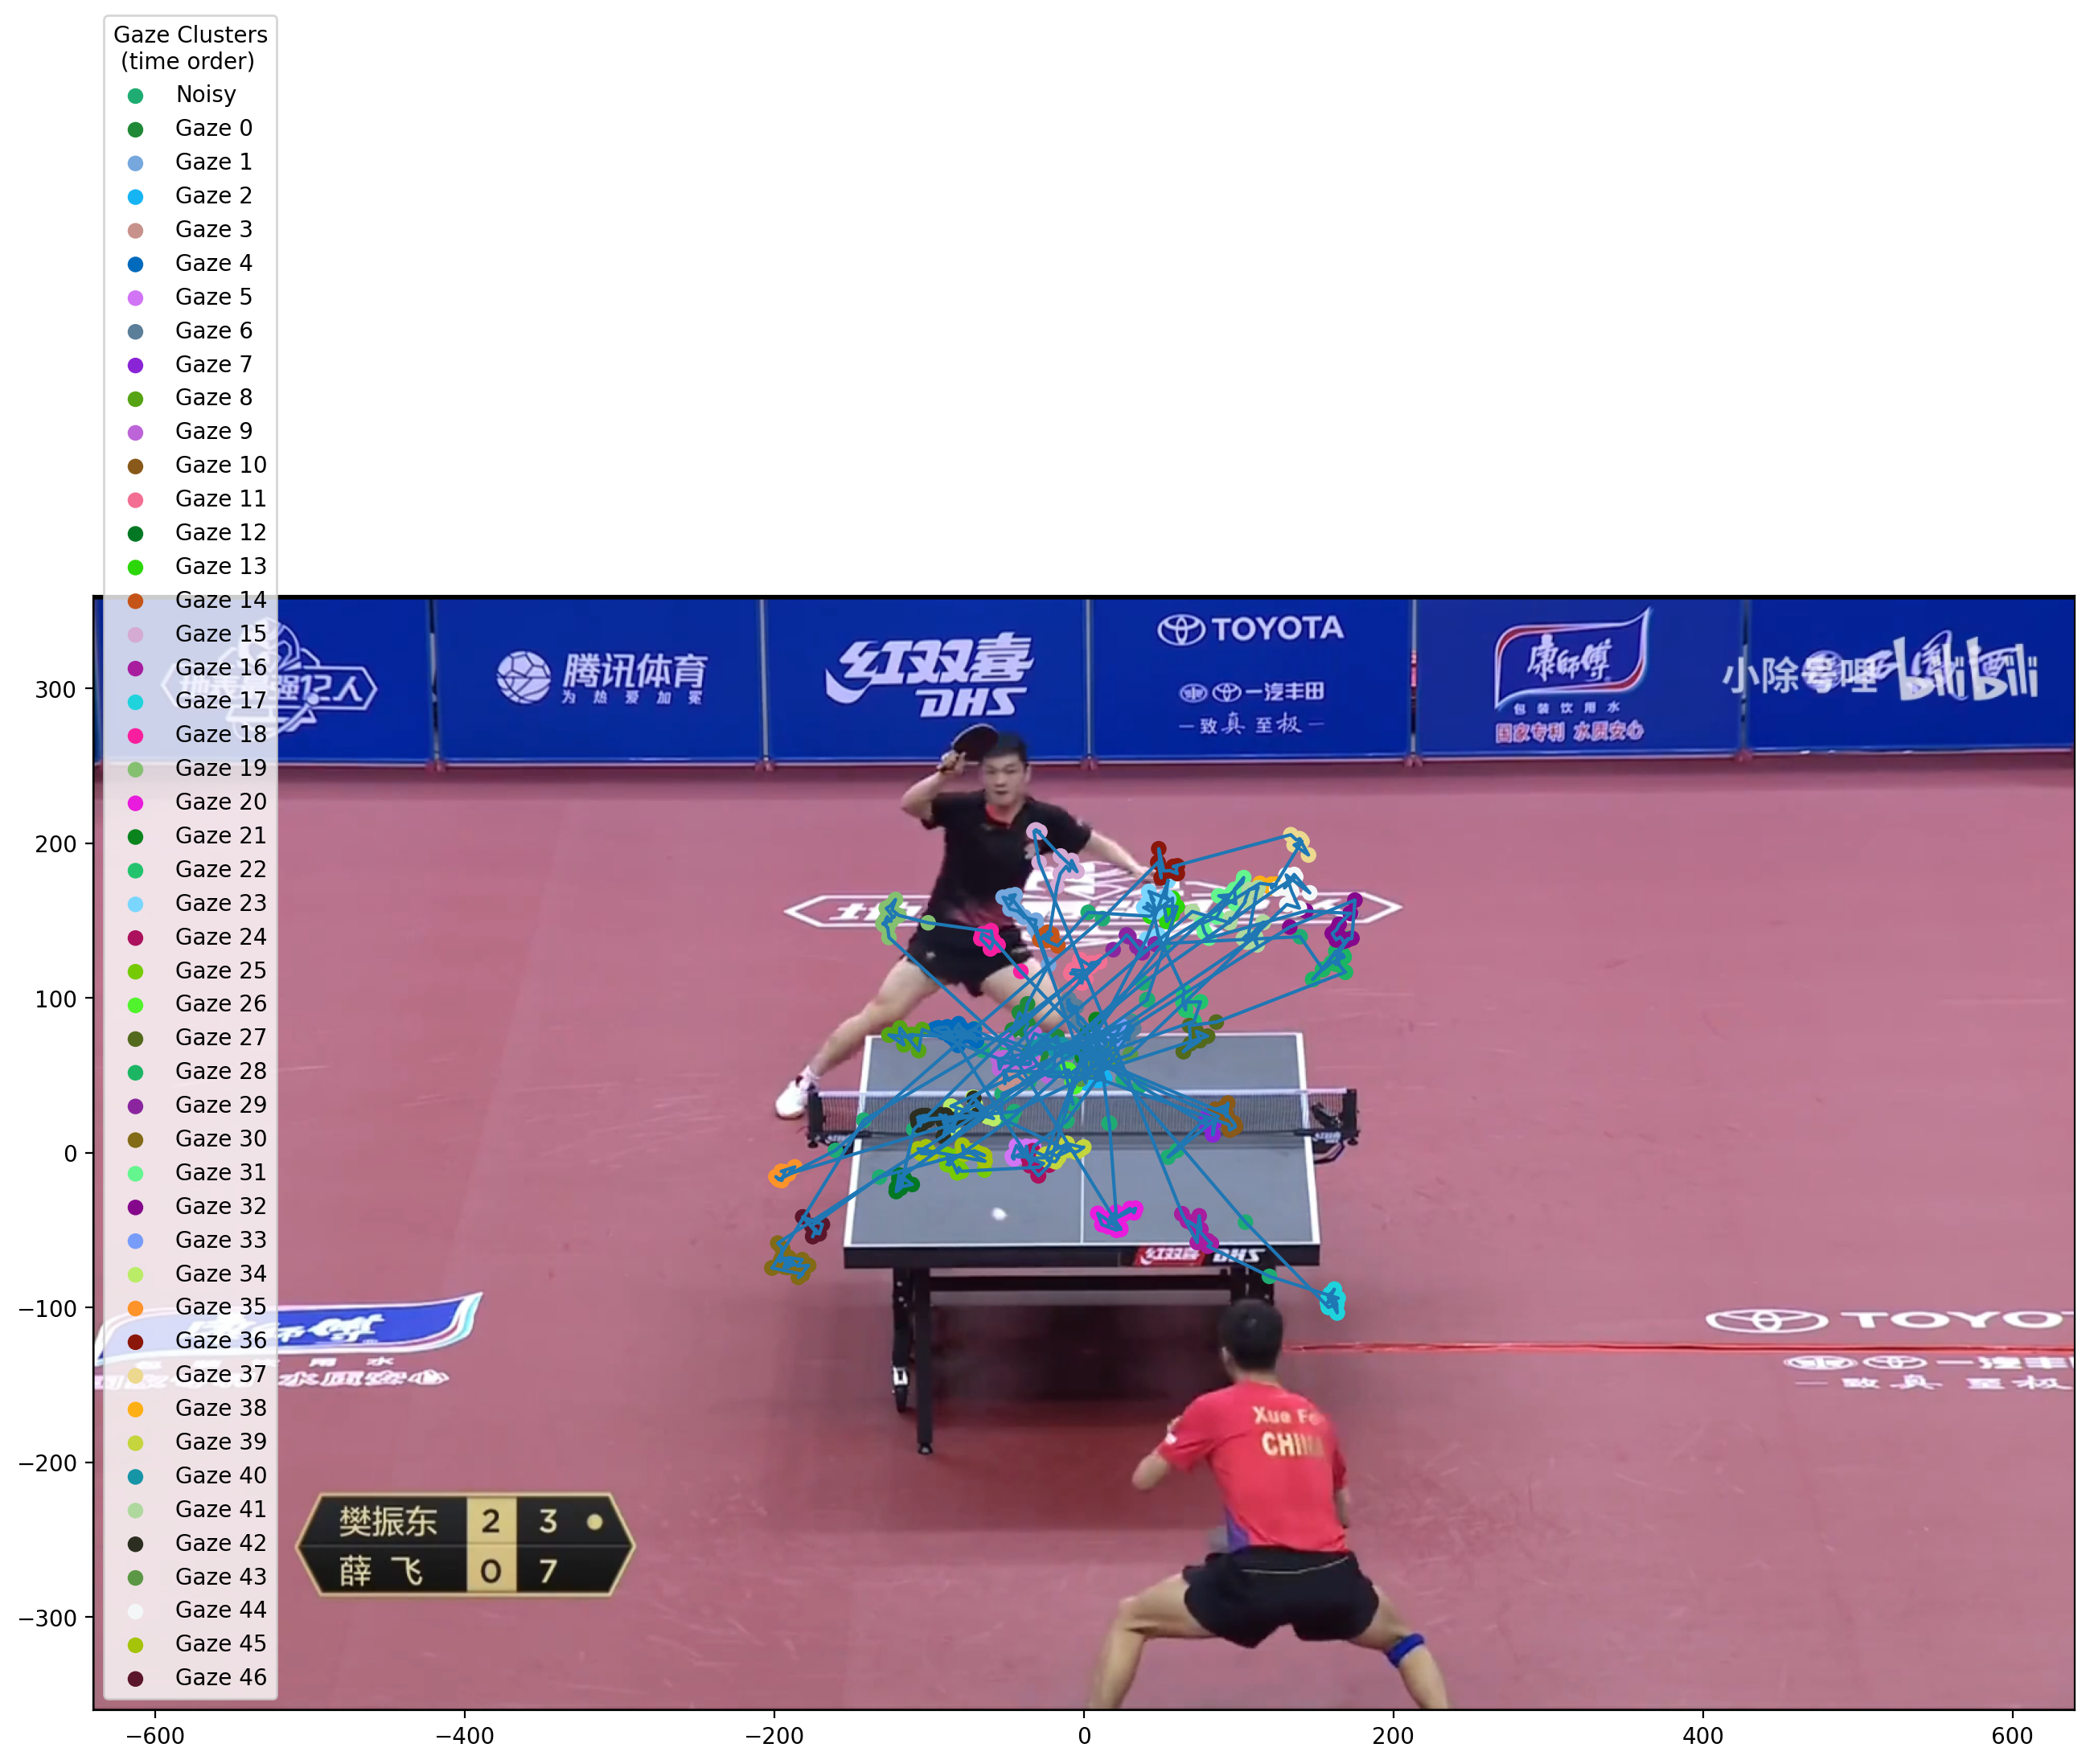

In [17]:
# plt.figure()
fig, ax=plt.subplots(figsize=(16,9),dpi=200)

img = plt.imread("p7.jpg")
for idx, cluster in temp.groupby(by="c"):
    # if idx>5: continue
    label = ("Noisy") if idx==-1 else f"Gaze {idx}"
    ax.scatter(x=cluster["x"], y=cluster["y"], c=cluster["color"], label=label)
ax.plot(temp["x"], temp["y"])
# plt.scatter(x=eye_data["Screen.x"], y=eye_data["Screen.y"])
# plt.plot(eye_data["Screen.x"], eye_data["Screen.y"])
# ax.imshow(img, extent=[-640,640,-360,360])

# legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="Gaze Clusters (time order)")
# ax.add_artist(legend1)

ax.legend( title="Gaze Clusters\n (time order)", loc="lower left")
ax.imshow(img, extent=[-640, 640, -360, 360])
# plt.xlim(-640,640)

In [18]:
VIDEO_FPS = 30

eye_data["frame"] = eye_data.index
eye_data.ffill(inplace=True)
eye_data.bfill(inplace=True)

aligned_df = interplate_and_align(eye_data, ball_data, EYE_SAMPLE_RATE, VIDEO_FPS)

In [19]:
aligned_df

Screen.x  Screen.y  LeftPupil  RightPupil  frame      Ball.x  \
1     -6.936387  31.41264   3.760830    2.750577      1  132.666667   
2    -17.236250  74.94171   3.472282    2.975615      2  131.466667   
3    -26.844490  67.97930   3.625612    3.156161      3  127.866667   
4    -27.533650  63.76825   3.764647    3.302529      4  122.400000   
5    -34.519730  66.01138   3.849909    3.203750      5  116.000000   
..          ...       ...        ...         ...    ...         ...   
819 -172.378700 -52.00825   4.150671    3.772168    819 -121.333333   
820 -172.451200 -52.26285   4.150671    3.772168    820 -121.333333   
821 -173.047500 -49.60559   4.202515    3.625865    821 -121.333333   
822 -174.990900 -54.17878   4.149105    3.789877    822 -121.333333   
823 -174.990900 -54.17878   4.149105    3.789877    823 -121.333333   

         Ball.y  round  
1    102.666667    1.0  
2     98.400000    1.0  
3     85.600000    1.0  
4     70.133333    1.0  
5     53.333333    1.0  
..          ...    ...  
819 -166.000000   25.0  
820 -166.000000   25.0  
821 -166.000000   25.0  
822 -166.000000   25.0  
823 -166.000000   25.0  

[823 rows x 8 columns]

In [20]:
import numpy as np

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    # theta = np.arctan2(y, x)
    theta = np.sin(np.arctan2( y , x ))
    return theta

In [21]:
aligned_df["hit"] = aligned_df["round"] - aligned_df["round"].shift(1, fill_value=1)

In [22]:
aligned_df["EyePolar"] = aligned_df.apply(lambda row : cartesian_to_polar(row["Screen.x"], row["Screen.y"]), axis=1)
aligned_df["BallPolar"] = aligned_df.apply(lambda row : cartesian_to_polar(row["Ball.x"], row["Ball.y"]), axis=1)

In [23]:
aligned_df["e_shift_x"] = aligned_df["Screen.x"].shift(1)
aligned_df["e_shift_y"] = aligned_df["Screen.y"].shift(1)
aligned_df["b_shift_x"] = aligned_df["Ball.x"].shift(1)
aligned_df["b_shift_y"] = aligned_df["Ball.y"].shift(1)

aligned_df["EyeDist"] = aligned_df.apply(lambda row : np.sqrt((row["Screen.x"] - row["e_shift_x"])**2 + (row["Screen.y"] - row["e_shift_y"])**2), axis=1)
aligned_df["BallDist"] = aligned_df.apply(lambda row : np.sqrt((row["Ball.x"] - row["b_shift_x"])**2 + (row["Ball.y"] - row["b_shift_y"])**2), axis=1)

aligned_df.drop(["e_shift_x","e_shift_y","b_shift_x","b_shift_y"], axis=1)

Screen.x  Screen.y  LeftPupil  RightPupil  frame      Ball.x  \
1     -6.936387  31.41264   3.760830    2.750577      1  132.666667   
2    -17.236250  74.94171   3.472282    2.975615      2  131.466667   
3    -26.844490  67.97930   3.625612    3.156161      3  127.866667   
4    -27.533650  63.76825   3.764647    3.302529      4  122.400000   
5    -34.519730  66.01138   3.849909    3.203750      5  116.000000   
..          ...       ...        ...         ...    ...         ...   
819 -172.378700 -52.00825   4.150671    3.772168    819 -121.333333   
820 -172.451200 -52.26285   4.150671    3.772168    820 -121.333333   
821 -173.047500 -49.60559   4.202515    3.625865    821 -121.333333   
822 -174.990900 -54.17878   4.149105    3.789877    822 -121.333333   
823 -174.990900 -54.17878   4.149105    3.789877    823 -121.333333   

         Ball.y  round  hit  EyePolar  BallPolar    EyeDist   BallDist  
1    102.666667    1.0  0.0  0.976477   0.612013        NaN        NaN  
2     98.400000    1.0  0.0  0.974556   0.599220  44.731053   4.432205  
3     85.600000    1.0  0.0  0.930106   0.556299  11.865641  13.296616  
4     70.133333    1.0  0.0  0.918076   0.497156   4.267070  16.404335  
5     53.333333    1.0  0.0  0.886149   0.417733   7.337366  17.977764  
..          ...    ...  ...       ...        ...        ...        ...  
819 -166.000000   25.0  0.0 -0.288849  -0.807332  13.878774   0.000000  
820 -166.000000   25.0  0.0 -0.290032  -0.807332   0.264721   0.000000  
821 -166.000000   25.0  0.0 -0.275560  -0.807332   2.723344   0.000000  
822 -166.000000   25.0  0.0 -0.295758  -0.807332   4.968991   0.000000  
823 -166.000000   25.0  0.0 -0.295758  -0.807332   0.000000   0.000000  

[823 rows x 13 columns]

In [24]:


# aligned_df["EyeArctan"] = aligned_df.apply(lambda row : np.arctan((row["Screen.y"] / row["Screen.x"]) / 4), axis=1)
# aligned_df["BallArctan"] = aligned_df.apply(lambda row : np.arctan((row["Ball.y"] / row["Ball.x"]) / 4), axis=1)
# aligned_df["EyeArctan"] = aligned_df.apply(lambda row : np.sin(np.arctan2(row["Screen.y"]-aligned_df["Screen.y"].mean(), row["Screen.x"]-aligned_df["Screen.x"].mean())), axis=1)
# aligned_df["BallArctan"] = aligned_df.apply(lambda row : np.sin(np.arctan2(row["Ball.y"], row["Ball.x"])), axis=1)
# aligned_df["EyeArctan"] =  sigmoid(aligned_df.apply(lambda row : row["Screen.y"] / row["Screen.x"], axis=1))
# aligned_df["BallArctan"] = sigmoid(aligned_df.apply(lambda row : row["Ball.y"] / row["Ball.x"], axis=1))
# aligned_df["EyeArctan"] =  sigmoid(aligned_df.apply(lambda row : row["Screen.y"] / row["Screen.x"], axis=1))
# aligned_df["BallArctan"] = sigmoid(aligned_df.apply(lambda row : row["Ball.y"] / row["Ball.x"], axis=1))

In [25]:
aligned_df

Screen.x  Screen.y  LeftPupil  RightPupil  frame      Ball.x  \
1     -6.936387  31.41264   3.760830    2.750577      1  132.666667   
2    -17.236250  74.94171   3.472282    2.975615      2  131.466667   
3    -26.844490  67.97930   3.625612    3.156161      3  127.866667   
4    -27.533650  63.76825   3.764647    3.302529      4  122.400000   
5    -34.519730  66.01138   3.849909    3.203750      5  116.000000   
..          ...       ...        ...         ...    ...         ...   
819 -172.378700 -52.00825   4.150671    3.772168    819 -121.333333   
820 -172.451200 -52.26285   4.150671    3.772168    820 -121.333333   
821 -173.047500 -49.60559   4.202515    3.625865    821 -121.333333   
822 -174.990900 -54.17878   4.149105    3.789877    822 -121.333333   
823 -174.990900 -54.17878   4.149105    3.789877    823 -121.333333   

         Ball.y  round  hit  EyePolar  BallPolar   e_shift_x  e_shift_y  \
1    102.666667    1.0  0.0  0.976477   0.612013         NaN        NaN   
2     98.400000    1.0  0.0  0.974556   0.599220   -6.936387   31.41264   
3     85.600000    1.0  0.0  0.930106   0.556299  -17.236250   74.94171   
4     70.133333    1.0  0.0  0.918076   0.497156  -26.844490   67.97930   
5     53.333333    1.0  0.0  0.886149   0.417733  -27.533650   63.76825   
..          ...    ...  ...       ...        ...         ...        ...   
819 -166.000000   25.0  0.0 -0.288849  -0.807332 -181.492700  -41.54138   
820 -166.000000   25.0  0.0 -0.290032  -0.807332 -172.378700  -52.00825   
821 -166.000000   25.0  0.0 -0.275560  -0.807332 -172.451200  -52.26285   
822 -166.000000   25.0  0.0 -0.295758  -0.807332 -173.047500  -49.60559   
823 -166.000000   25.0  0.0 -0.295758  -0.807332 -174.990900  -54.17878   

      b_shift_x   b_shift_y    EyeDist   BallDist  
1           NaN         NaN        NaN        NaN  
2    132.666667  102.666667  44.731053   4.432205  
3    131.466667   98.400000  11.865641  13.296616  
4    127.866667   85.600000   4.267070  16.404335  
5    122.400000   70.133333   7.337366  17.977764  
..          ...         ...        ...        ...  
819 -121.333333 -166.000000  13.878774   0.000000  
820 -121.333333 -166.000000   0.264721   0.000000  
821 -121.333333 -166.000000   2.723344   0.000000  
822 -121.333333 -166.000000   4.968991   0.000000  
823 -121.333333 -166.000000   0.000000   0.000000  

[823 rows x 17 columns]

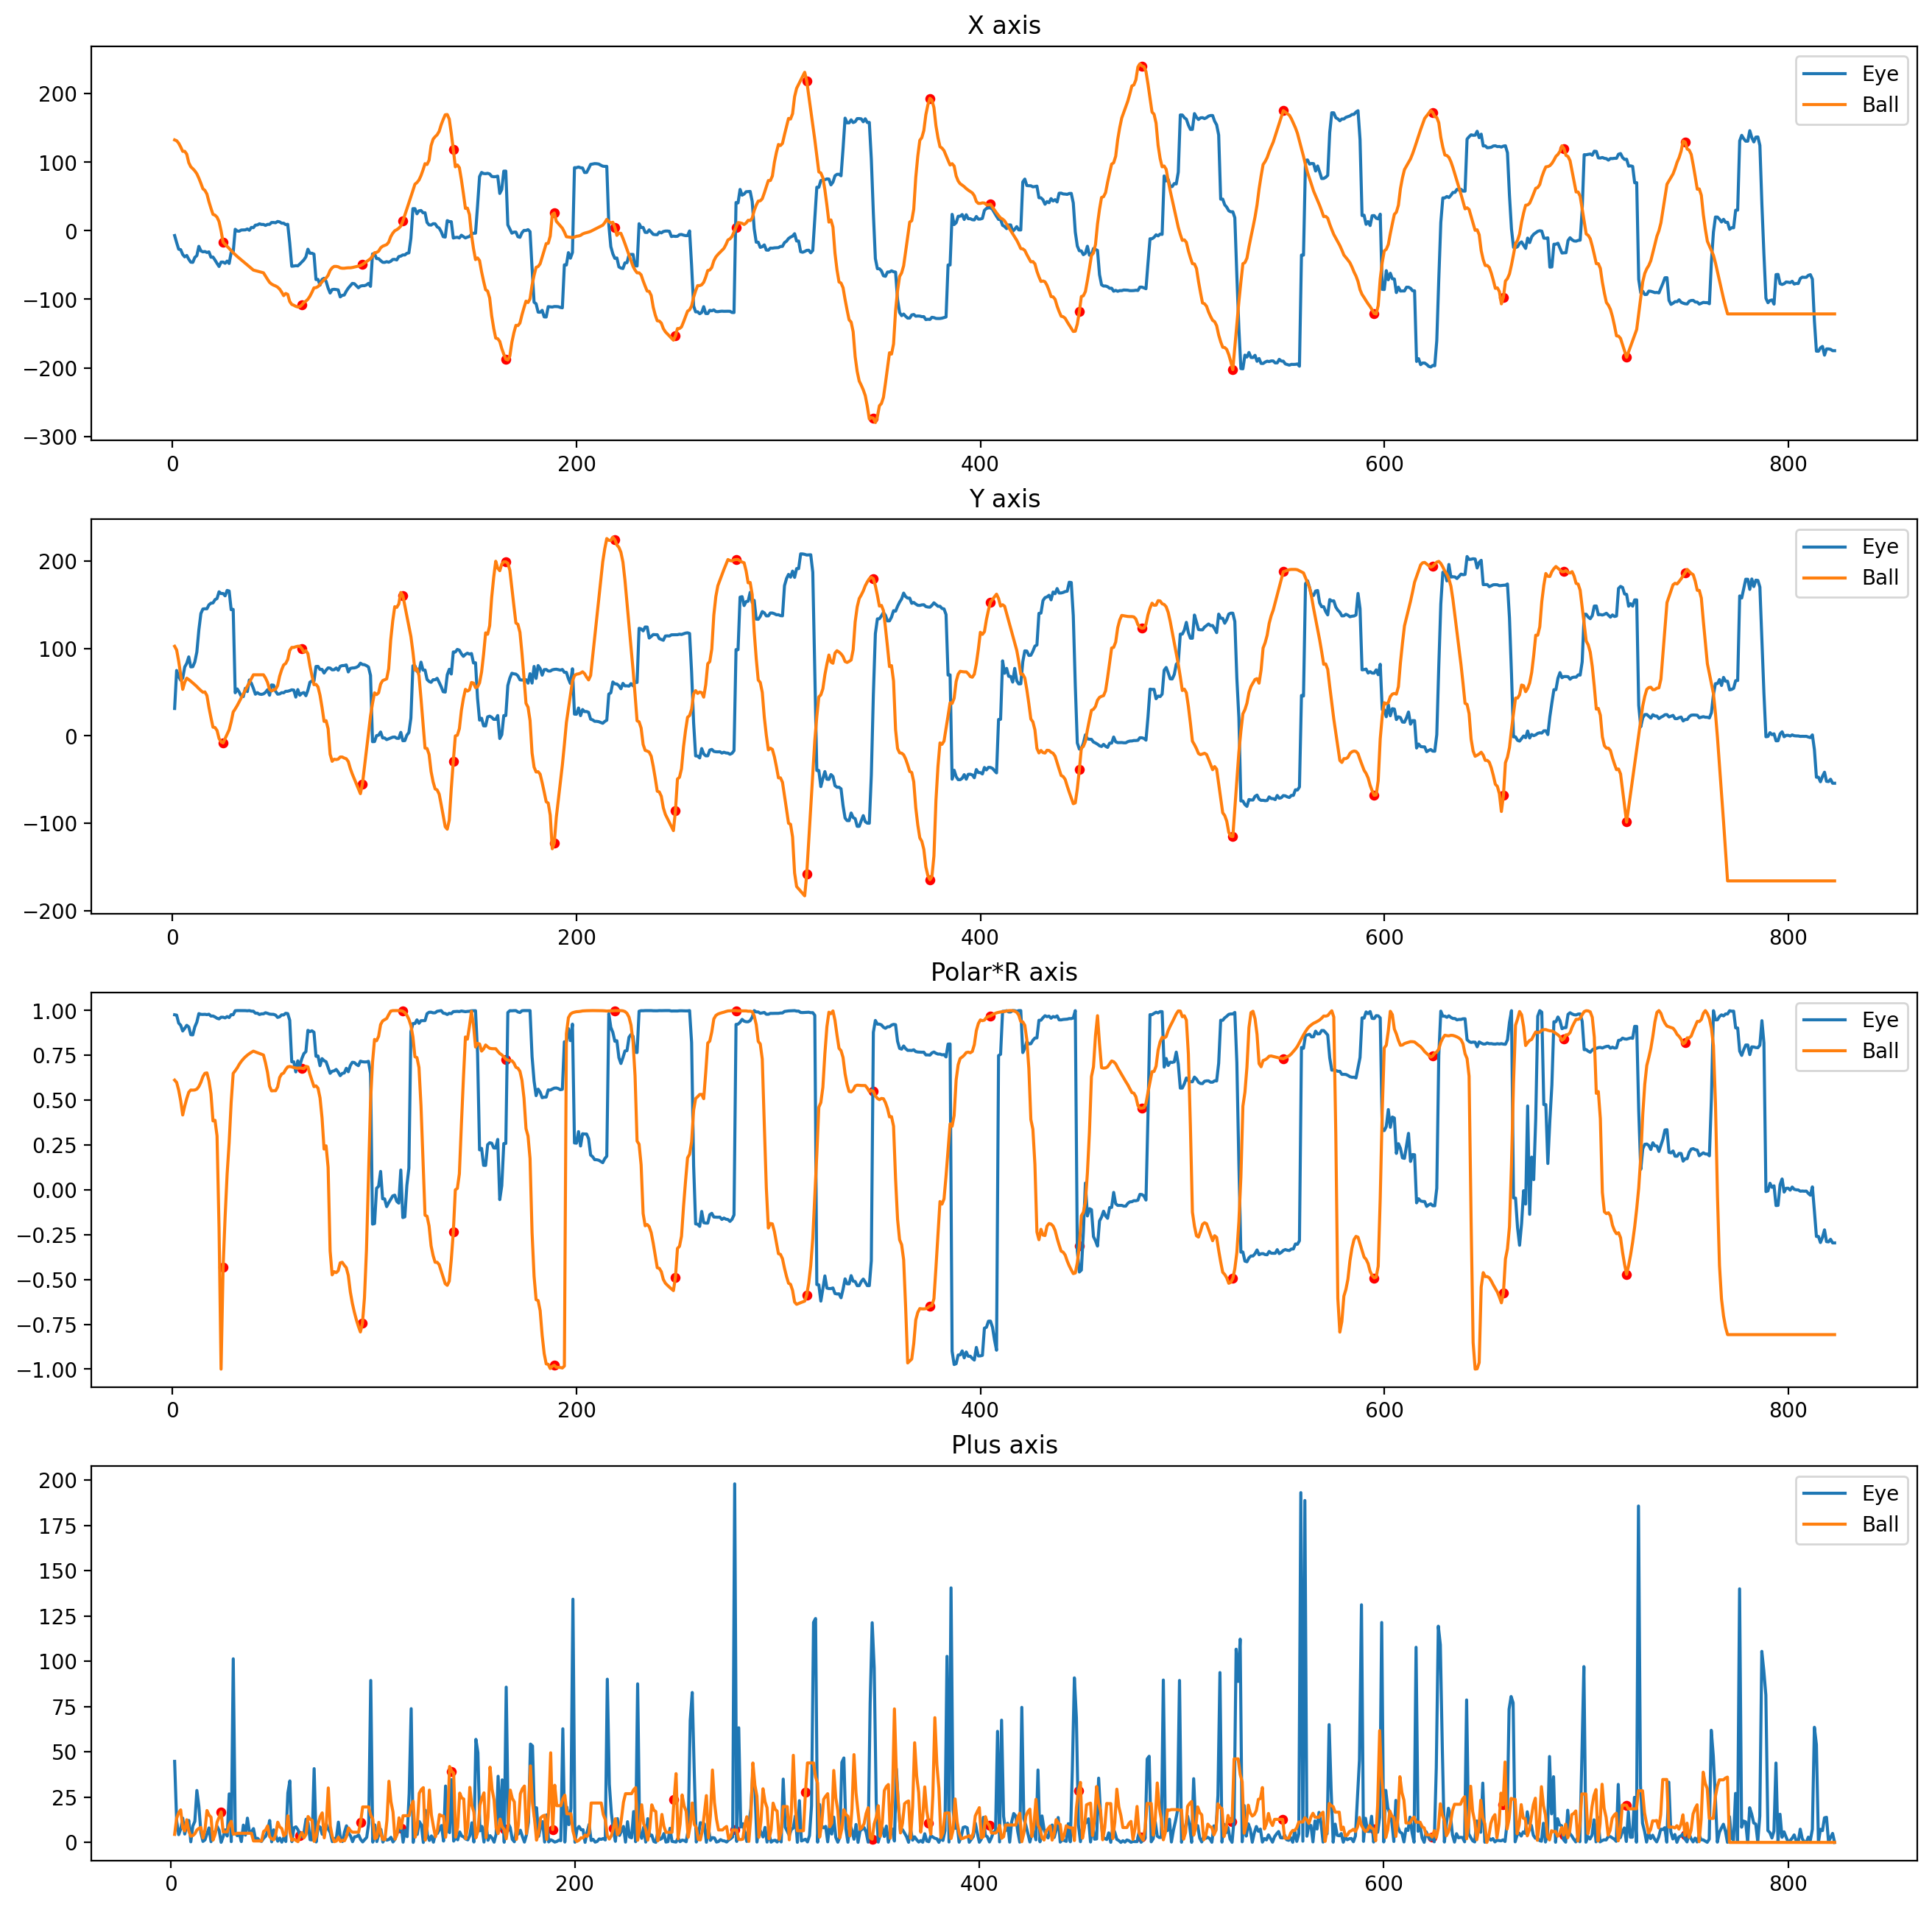

In [26]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(16,16),dpi=200)


axs[0].plot(aligned_df["Screen.x"], label="Eye")
axs[0].plot(aligned_df["Ball.x"], label="Ball")
axs[0].scatter(aligned_df[aligned_df["hit"]==1]["frame"], aligned_df[aligned_df["hit"]==1]["Ball.x"], s=15, c="red")
axs[0].set_title("X axis")
axs[0].legend()

axs[1].plot(aligned_df["Screen.y"], label="Eye")
axs[1].plot(aligned_df["Ball.y"], label="Ball")
axs[1].scatter(aligned_df[aligned_df["hit"]==1]["frame"], aligned_df[aligned_df["hit"]==1]["Ball.y"], s=15, c="red")
axs[1].set_title("Y axis")
axs[1].legend()

axs[2].plot(aligned_df["EyePolar"], label="Eye")
axs[2].plot(aligned_df["BallPolar"], label="Ball")
axs[2].scatter(aligned_df[aligned_df["hit"]==1]["frame"], aligned_df[aligned_df["hit"]==1]["BallPolar"], s=15, c="red")
axs[2].set_title("Polar*R axis")
axs[2].legend()

axs[3].plot(aligned_df["EyeDist"], label="Eye")
axs[3].plot(aligned_df["BallDist"], label="Ball")
axs[3].scatter(aligned_df[aligned_df["hit"]==1]["frame"], aligned_df[aligned_df["hit"]==1]["BallDist"], s=15, c="red")
axs[3].set_title("Plus axis")
axs[3].legend()
# axs[3].plot(aligned_df["EyeArctan"], label="Eye")
# axs[3].plot(aligned_df["BallArctan"], label="Ball")
# axs[3].scatter(aligned_df[aligned_df["hit"]==1]["frame"], aligned_df[aligned_df["hit"]==1]["BallArctan"], s=15, c="red")
# axs[3].set_title("Plus axis")
# axs[3].legend()

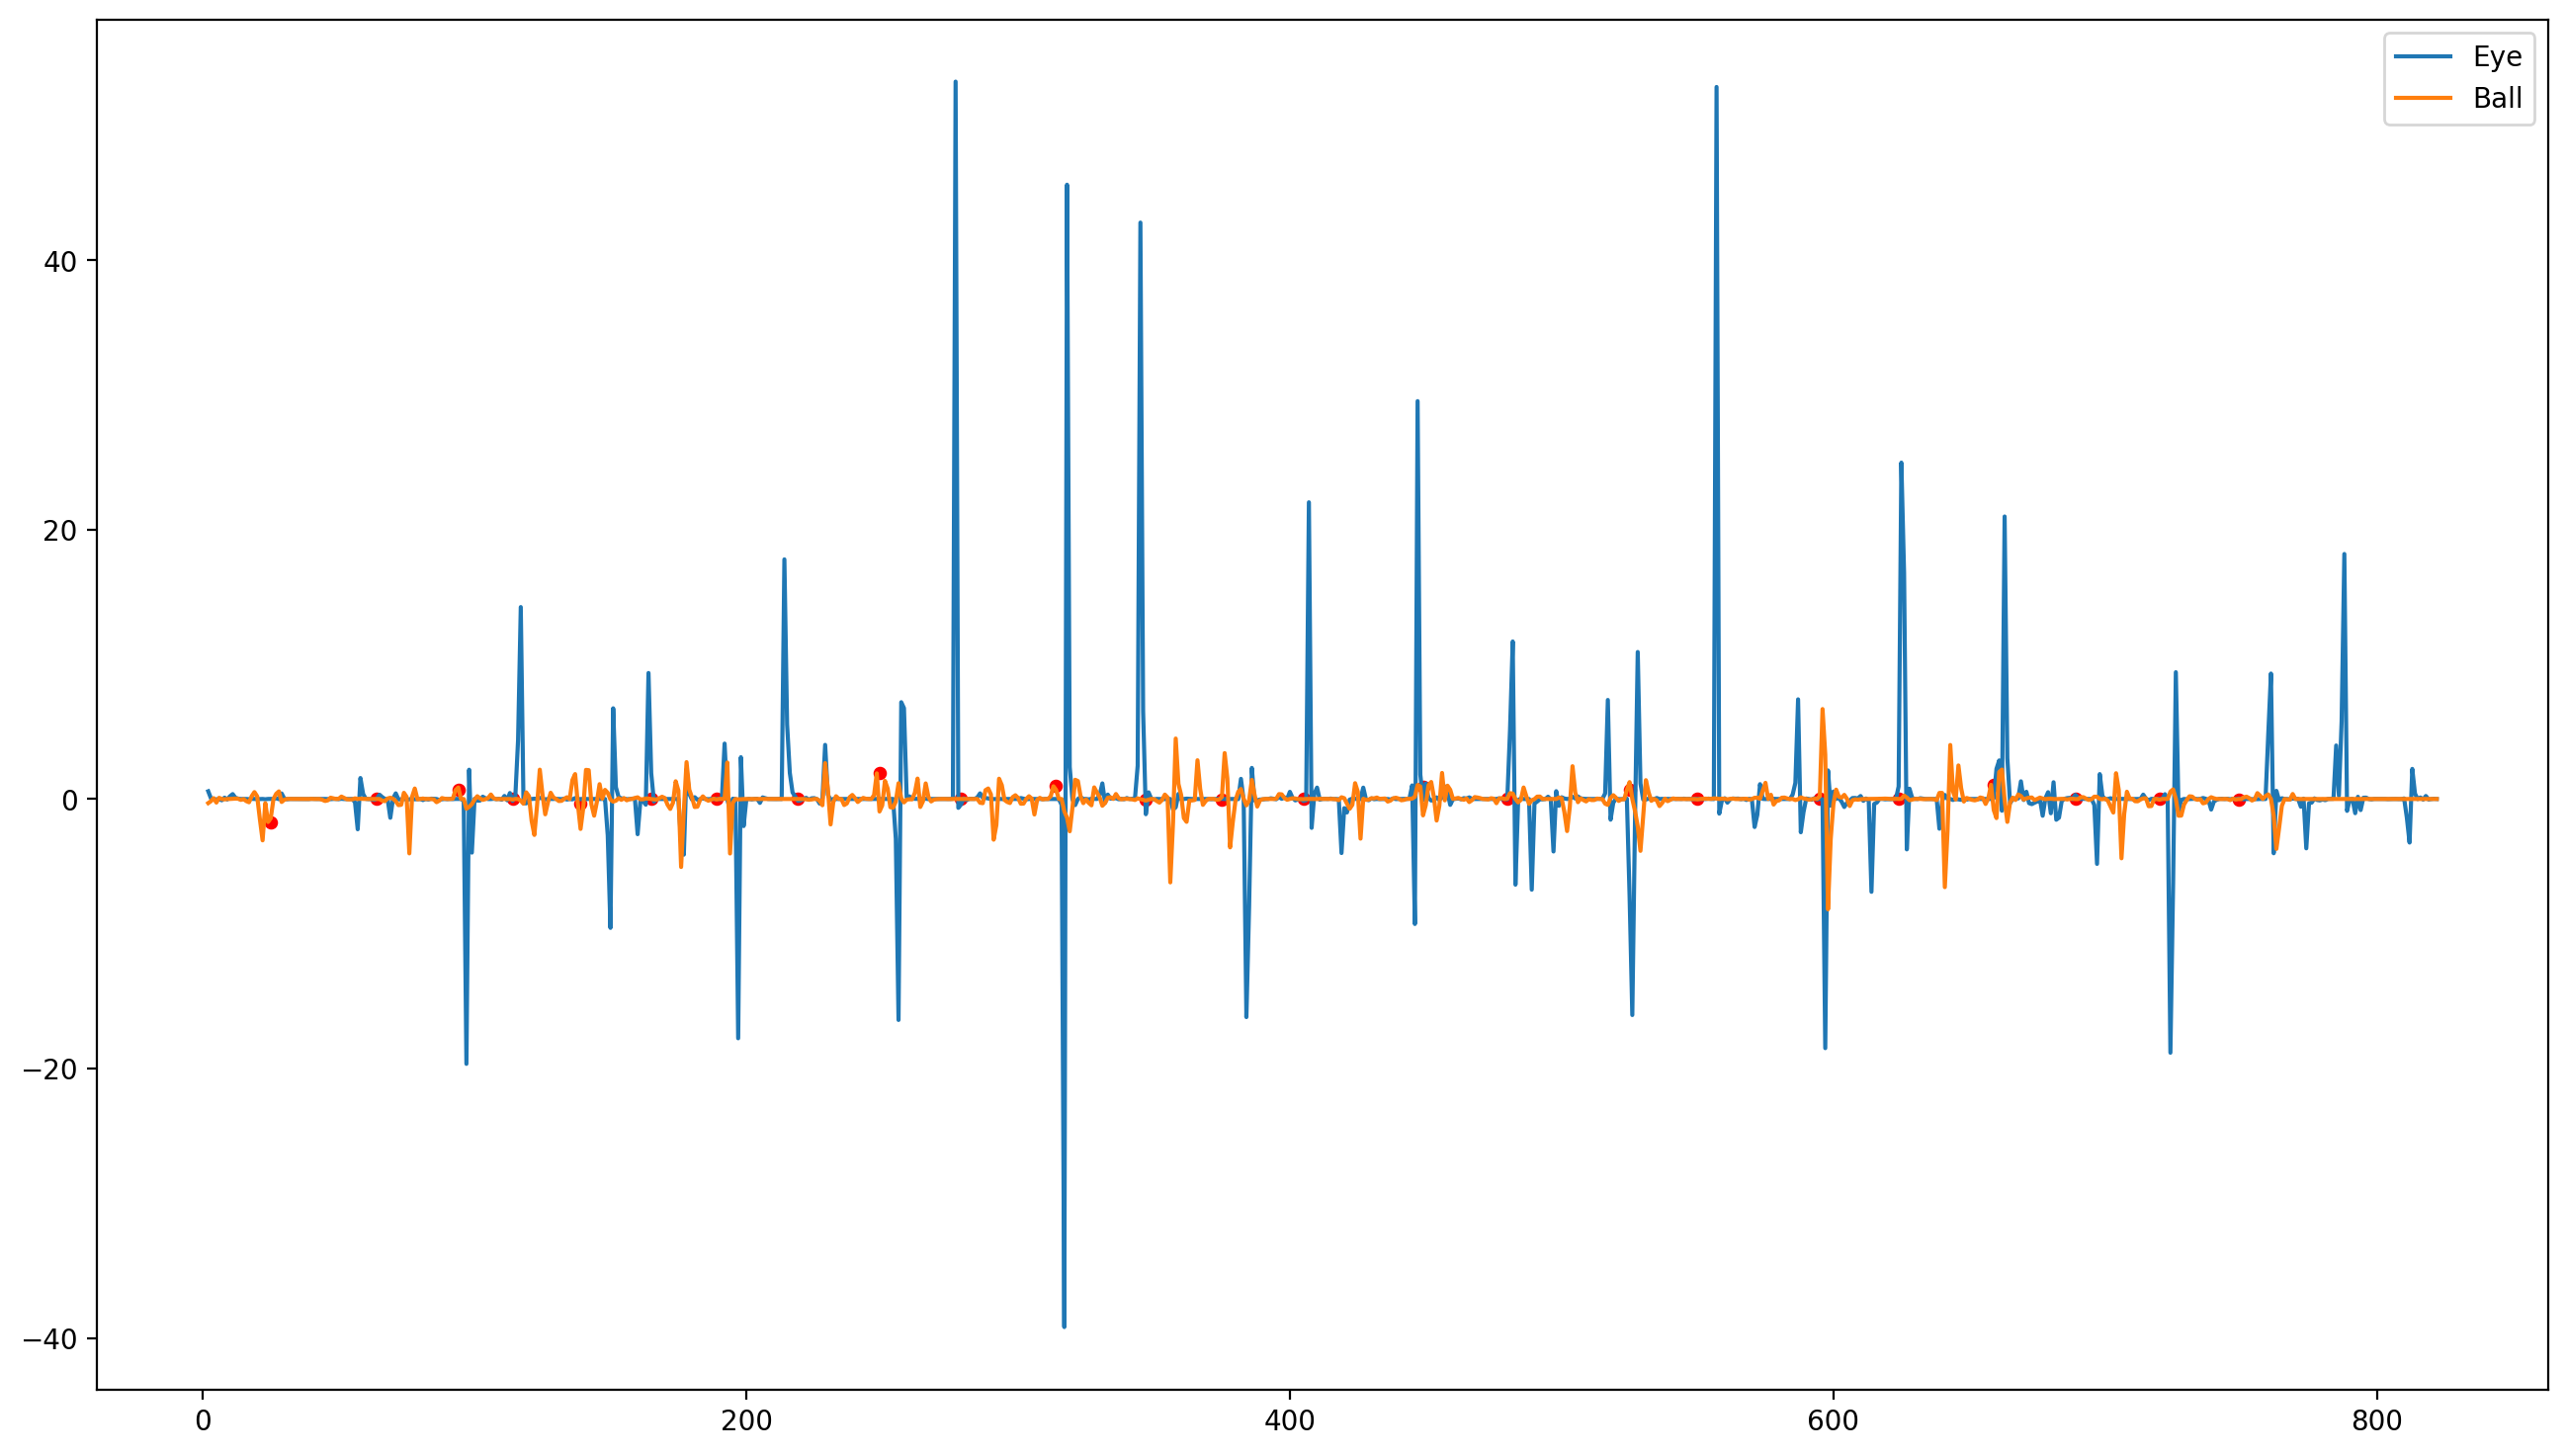

In [27]:
fig, ax=plt.subplots(figsize=(16,9),dpi=200)

# ax.plot(np.gradient(aligned_df["EyePolar"]), label="Eye")
# ax.plot(np.gradient(aligned_df["BallPolar"]), label="Ball")

ax.plot(np.gradient(aligned_df["EyePolar"]) * np.gradient(aligned_df["EyeDist"]), label="Eye")
ax.plot(np.gradient(aligned_df["BallPolar"]) * np.gradient(aligned_df["BallDist"]), label="Ball")
# ax.plot(np.gradient(aligned_df["Screen.y"]) , label="Eye-Y")
# ax.plot(np.gradient(aligned_df["Ball.y"]) , label="Ball-Y")

# ax.plot(np.gradient(aligned_df["EyePolar"]) * np.gradient(aligned_df["Screen.y"]), label="Eye-Y")
# ax.plot(np.gradient(aligned_df["BallPolar"]) * np.gradient(aligned_df["Ball.y"]), label="Ball-Y")

ax.scatter(aligned_df[aligned_df["hit"]==1]["frame"], (np.gradient(aligned_df["BallPolar"]) * np.gradient(aligned_df["BallDist"]))[aligned_df["hit"]==1], s=15, c="red")
# ax.set_ylim(-100,100)

ax.legend()

In [28]:
eye_grad, ball_grad = compute_gradient(aligned_df.loc[:,["frame", "Screen.x", "Screen.y"]], aligned_df.loc[:,["frame", "Ball.x", "Ball.y"]])
eye_grad = eye_grad * VR_SCALE
ball_grad = ball_grad * VR_SCALE

NameError: name 'compute_gradient' is not defined

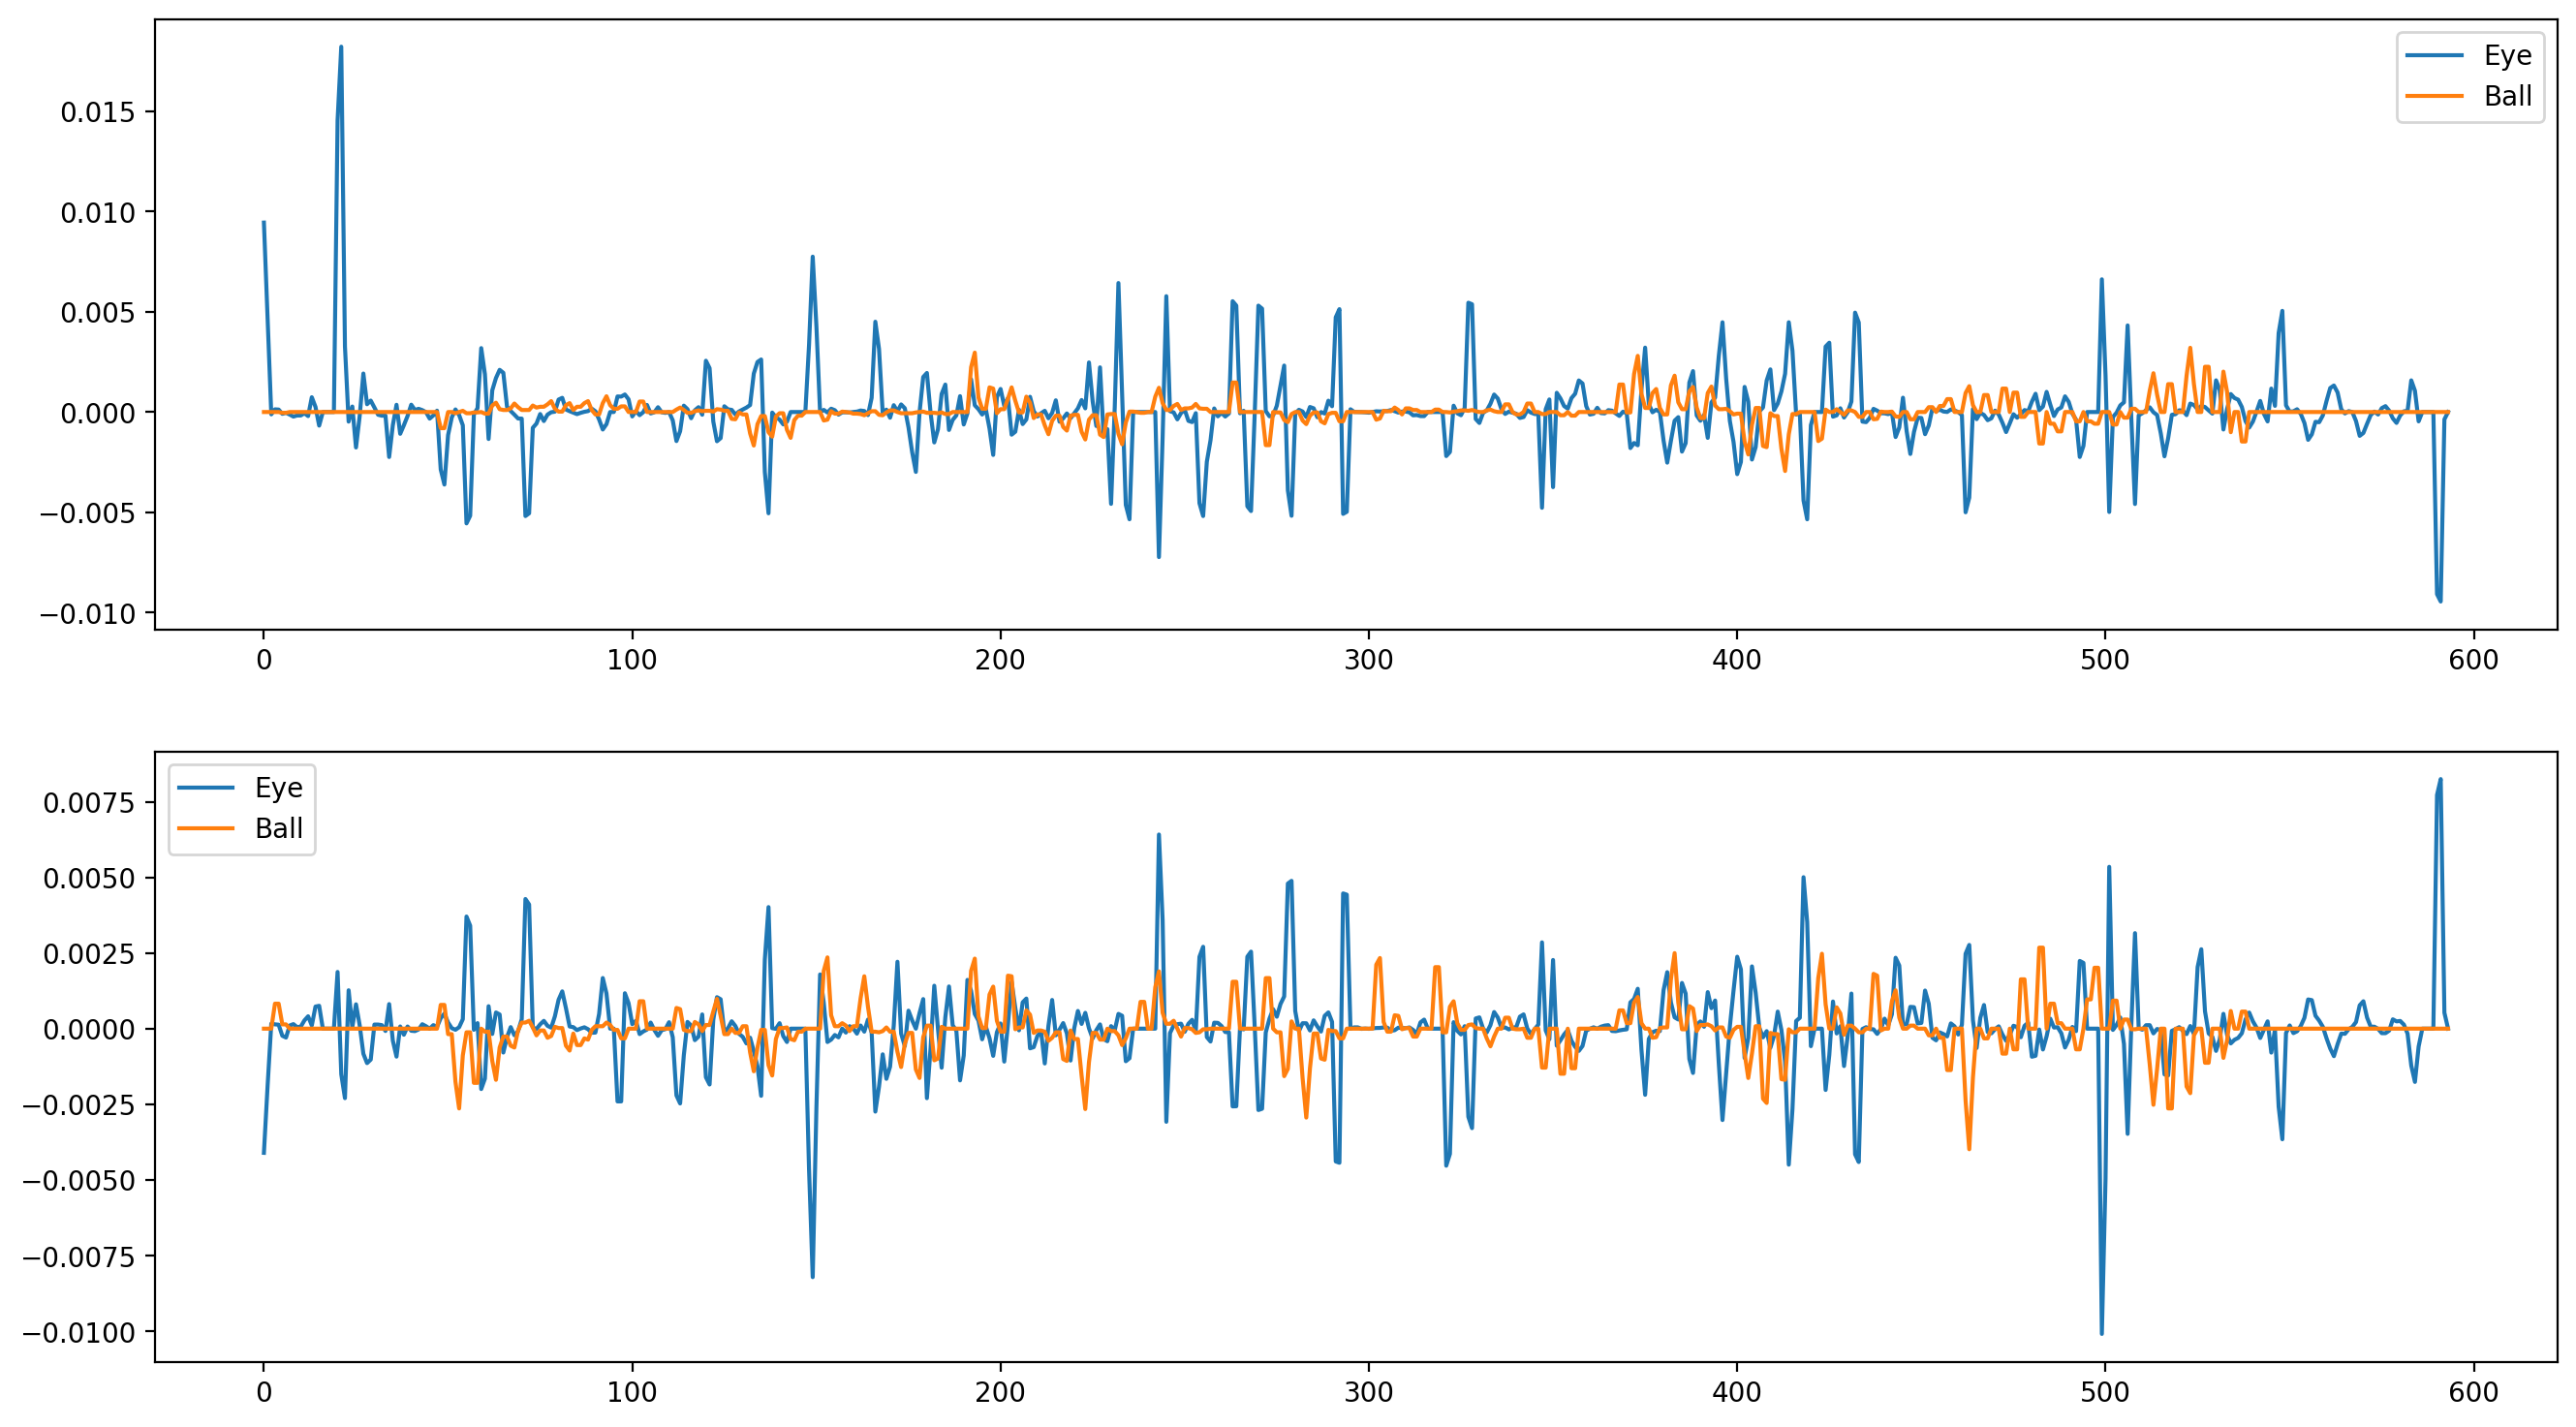

In [ ]:
# plt.figure()
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(16,9),dpi=200)


ax[0].plot(eye_grad["Screen.x.grad"], label="Eye")
ax[0].plot(ball_grad["Ball.x.grad"], label="Ball")
ax[0].legend()

ax[1].plot(eye_grad["Screen.y.grad"], label="Eye")
ax[1].plot(ball_grad["Ball.y.grad"], label="Ball")
ax[1].legend()

# ax.legend( title="Gaze Clusters\n (time order)", loc="lower left")
# ax.imshow(img, extent=[-640, 640, -360, 360])
# plt.xlim(-640,640)

In [ ]:
eye_grad, ball_grad = compute_gradient(aligned_df.loc[:,["frame", "Screen.x", "Screen.y"]], aligned_df.loc[:,["frame", "Ball.x", "Ball.y"]], order=2)

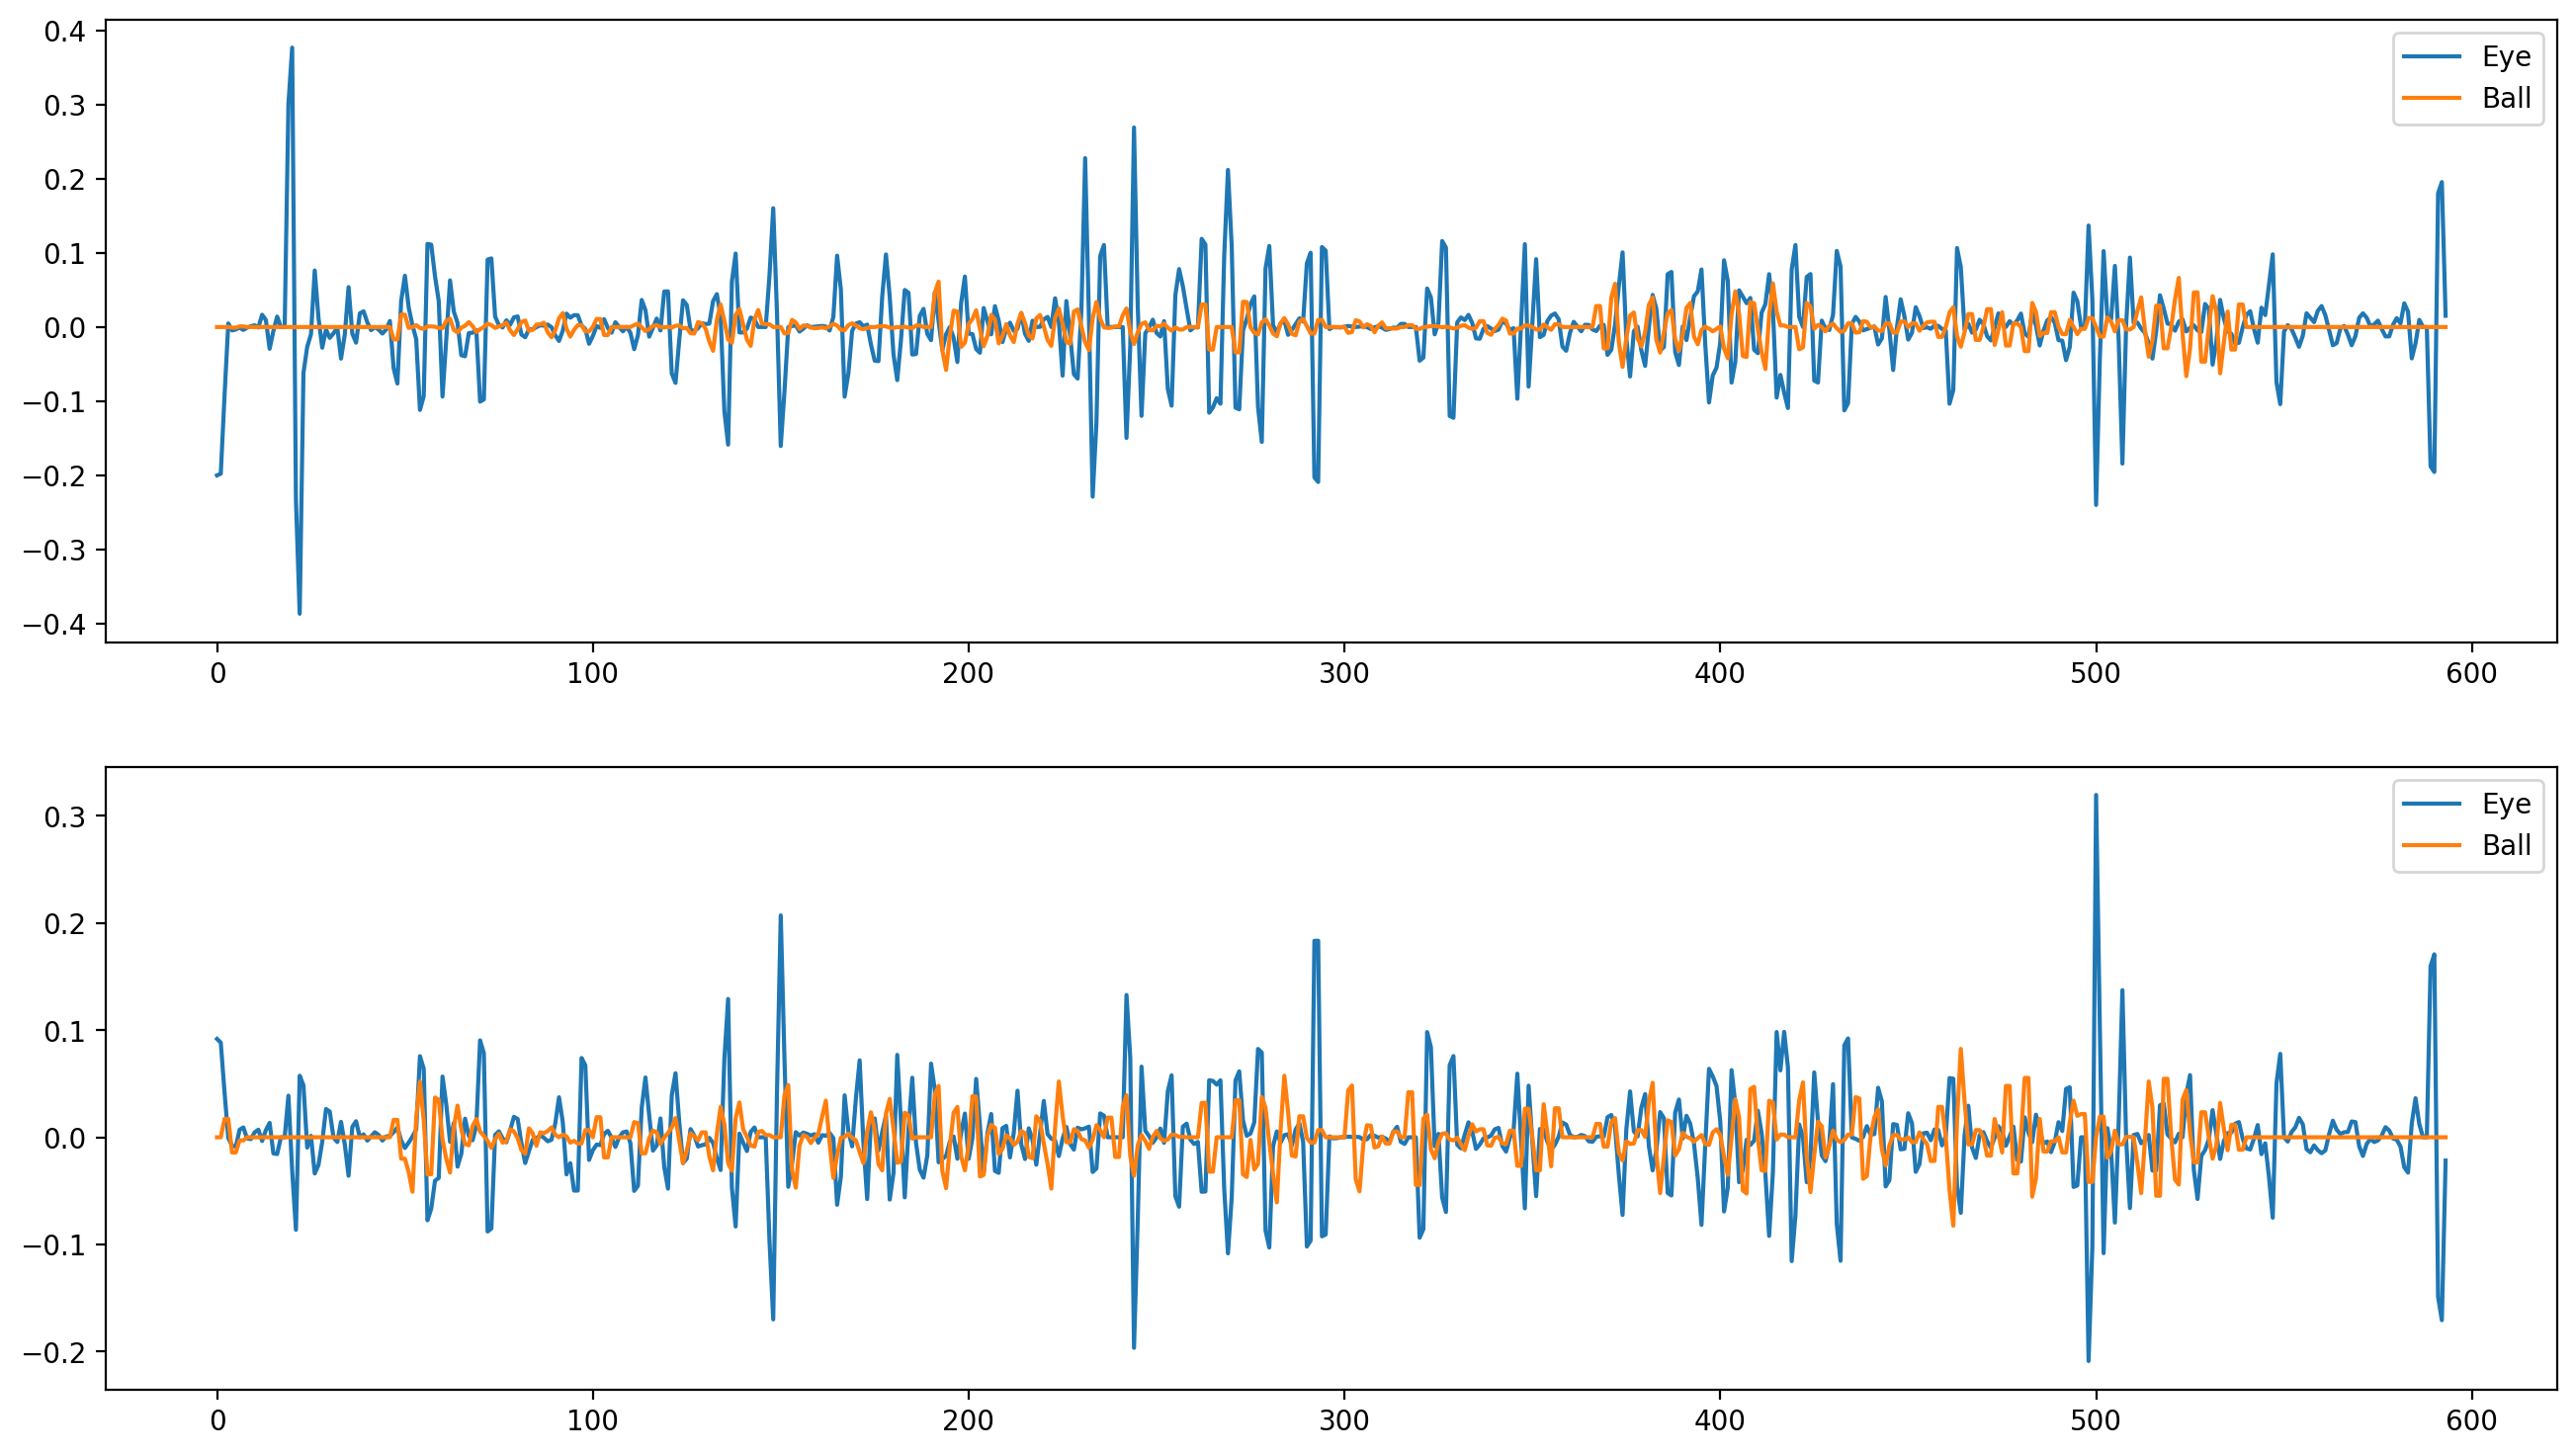

In [ ]:
# plt.figure()
fig, ax=plt.subplots(nrows=2, ncols=1, figsize=(16,9),dpi=200)


ax[0].plot(eye_grad["Screen.x.grad"], label="Eye")
ax[0].plot(ball_grad["Ball.x.grad"], label="Ball")
ax[0].legend()

ax[1].plot(eye_grad["Screen.y.grad"], label="Eye")
ax[1].plot(ball_grad["Ball.y.grad"], label="Ball")
ax[1].legend()

# ax.legend( title="Gaze Clusters\n (time order)", loc="lower left")
# ax.imshow(img, extent=[-640, 640, -360, 360])
# plt.xlim(-640,640)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_patterns(series1, series2, n_clusters=3):
    combined_data = np.vstack([series1, series2])
    scaler = StandardScaler()
    combined_data_scaled = scaler.fit_transform(combined_data)

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(combined_data_scaled)

    labels = kmeans.labels_
    return labels[:len(series1)], labels[len(series1):]

# Example data
data1 = {'time': [1, 2, 3, 4, 5], 'x': [1, 2, 3, 4, 5], 'y': [2, 3, 4, 5, 6]}
data2 = {'time': [1, 2, 3, 4, 5], 'x': [2, 3, 4, 5, 6], 'y': [3, 4, 5, 6, 7]}
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)

# Combining x and y coordinates into a single array
series1 = np.array(df1[['x', 'y']])
series2 = np.array(df2[['x', 'y']])

# Clustering patterns
labels1, labels2 = cluster_patterns(series1, series2)

print(f"Cluster labels for series 1: {labels1}")
print(f"Cluster labels for series 2: {labels2}")

Cluster labels for series 1: [1 1 2 2 0]
Cluster labels for series 2: [1 2 2 0 0]


/var/folders/rp/3xmh9dds7tl2vhpb6h3ntl1r0000gn/T/ipykernel_12609/326304470.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


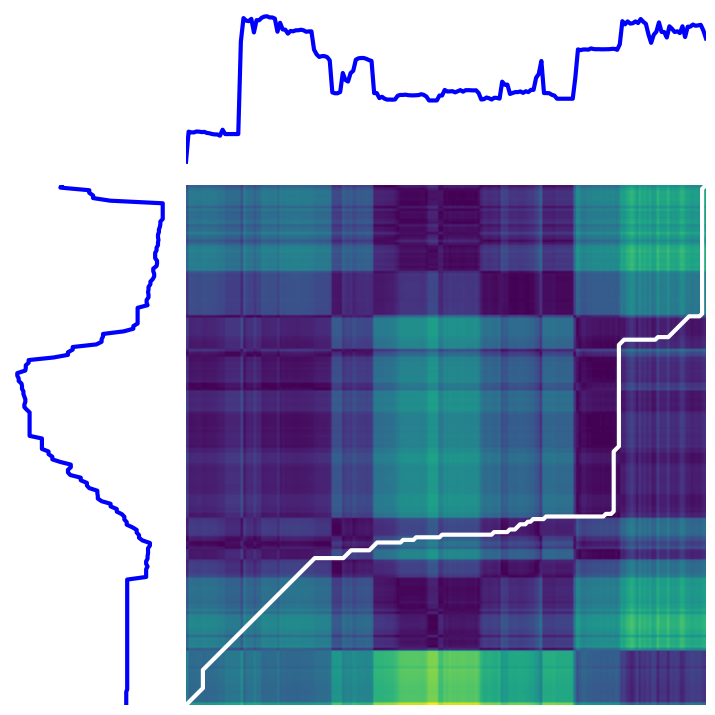

In [ ]:
import numpy
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tslearn import metrics

sz = 200
path, sim = metrics.dtw_path(aligned_df["Screen.x"][:sz], aligned_df["Ball.x"][:sz])
# sz = aligned_df.shape[0]

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = cdist(aligned_df.loc[:, ["Screen.x"]][:sz], aligned_df.loc[:, ["Screen.y"]][:sz])

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(numpy.arange(sz), aligned_df["Screen.x"][:sz], "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz - 1))

ax_s_y.plot(- aligned_df["Ball.x"][:sz], numpy.arange(sz), "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()

In [ ]:
eye_grad

frame.grad  Screen.x.grad  Screen.y.grad
0           0.0      -0.200105       0.091782
1           0.0      -0.197815       0.088375
2           0.0      -0.092598       0.042002
3           0.0       0.004916      -0.000726
4           0.0      -0.004641      -0.007822
..          ...            ...            ...
589         0.0      -0.187891       0.159853
590         0.0      -0.195483       0.170732
591         0.0       0.180298      -0.148974
592         0.0       0.195483      -0.170732
593         0.0       0.015184      -0.021758

[594 rows x 3 columns]

/var/folders/rp/3xmh9dds7tl2vhpb6h3ntl1r0000gn/T/ipykernel_12609/1049076587.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


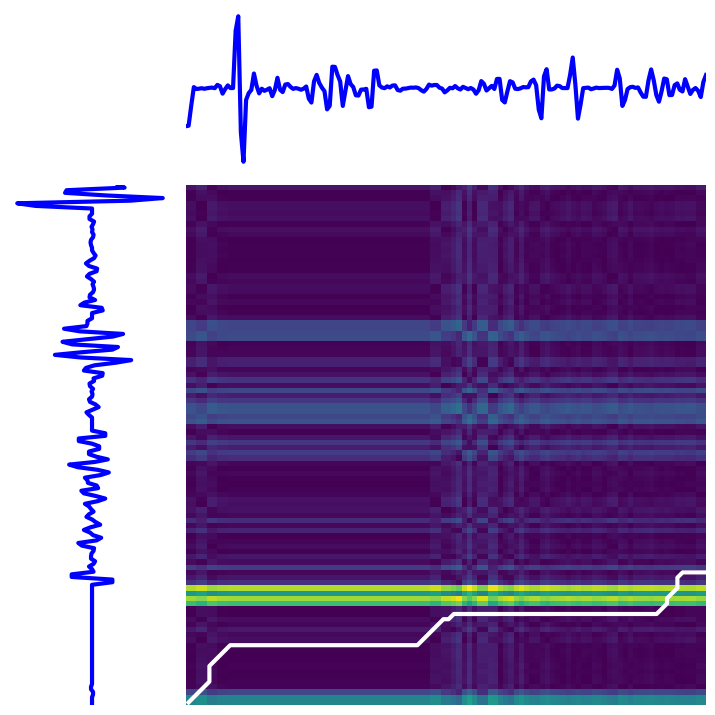

In [ ]:
sz = 200
path, sim = metrics.dtw_path(eye_grad["Screen.x.grad"][:sz], ball_grad["Ball.x.grad"][:sz])
# sz = aligned_df.shape[0]

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = cdist(eye_grad.loc[:, ["Screen.x.grad"]][:100], ball_grad.loc[:, ["Ball.y.grad"]][:100])

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(numpy.arange(sz), eye_grad["Screen.x.grad"][:sz], "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz - 1))

ax_s_y.plot(- ball_grad["Ball.x.grad"][:sz], numpy.arange(sz), "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()

In [ ]:

mat = cdist(eye_grad, ball_grad)

In [ ]:
mat.max()

0.4824317418714161